In [1]:
import numpy as np
from scipy.ndimage import convolve
from skimage import io
import math
import cv2

In [2]:
def scale_and_round(x):
    if x <= 0:
        return 0
    elif x >= 1:
        return 255
    else:
        return (255.0 * x + 0.5) % 256


def input2RGB(input_data):
    size = len(input_data) // 3
    R = np.array(input_data[:size]) / 255.0
    G = np.array(input_data[size : 2 * size]) / 255.0
    B = np.array(input_data[2 * size :]) / 255.0
    return R, G, B


def RGB2output(R, G, B, size):
    output = np.zeros(3 * size, dtype=np.uint8)
    for n in range(size):
        output[n] = scale_and_round(R[n])
        output[size + n] = scale_and_round(G[n])
        output[2 * size + n] = scale_and_round(B[n])
    return output

Save Histograms of image

In [3]:
import matplotlib.pyplot as plt

def make_histograms(image_path, save_path):
    image = cv2.imread(image_path)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    b, g, r = cv2.split(image)

    plt.figure(figsize=(2, 4))

    plt.subplot(411)
    plt.hist(r.flatten(), 256, [0, 256], color="red", alpha=0.9)
    plt.xticks([]), plt.yticks([])

    plt.subplot(412)
    plt.hist(g.flatten(), 256, [0, 256], color="green", alpha=0.9)
    plt.xticks([]), plt.yticks([])

    plt.subplot(413)
    plt.hist(b.flatten(), 256, [0, 256], color="blue", alpha=0.9)
    plt.xticks([]), plt.yticks([])

    plt.subplot(414)
    plt.hist(gray_image.flatten(), 256, [0, 256], color="gray", alpha=0.9)
    plt.xticks([]), plt.yticks([])

    plt.savefig(save_path, format="jpg")
    plt.close()
    return

Plot Images and Histograms

In [4]:
import matplotlib.pyplot as plt

def plot_output(in_image_path, in_histogram_path, out_image_path, out_histogram_path):
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))

    original_image = cv2.imread(in_image_path)
    make_histograms(in_image_path, in_histogram_path)
    original_hist = cv2.imread(in_histogram_path)

    final_image = cv2.imread(out_image_path)
    make_histograms(out_image_path, out_histogram_path)
    final_hist = cv2.imread(out_histogram_path)

    axs[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    axs[0, 1].imshow(cv2.cvtColor(original_hist, cv2.COLOR_BGR2RGB), aspect="auto")
    axs[0, 1].axis("off")

    axs[1, 0].imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    axs[1, 0].set_title("Final Image")
    axs[1, 0].axis("off")
    axs[1, 1].imshow(cv2.cvtColor(final_hist, cv2.COLOR_BGR2RGB), aspect="auto")
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

    return

Mask Image Computation

In [5]:
def Compute_Mask(radius, Dx, Dy):
    Mask = np.zeros(Dx * Dy)
    Mask2 = np.zeros(Dx * Dy)

    Kernel = np.exp(-2.0 * np.square(np.arange(-radius, radius + 1)) / (radius**2))
    Kernel /= np.sum(Kernel)

    if radius > 0:
        # If the radius of the mask is less than the mid-size of the image,
        # perform the desired algorithm
        if radius < Dx / 2 and radius < Dy / 2:
            # Convolve in the x direction
            Mask2 = convolve(Mask.reshape((Dx, Dy)), Kernel[np.newaxis, :], mode="constant", cval=0.0).flatten()
            # Convolve in the y direction
            Mask = convolve(Mask2.reshape((Dx, Dy)),Kernel[:, np.newaxis],mode="constant",cval=0.0,).flatten()
        else:
            # Otherwise, perform a simple gamma correction
            sum_val = np.sum(Mask)
            Mask = np.full_like(Mask, sum_val / (Dx * Dy))
    return Mask

LCC - RGB

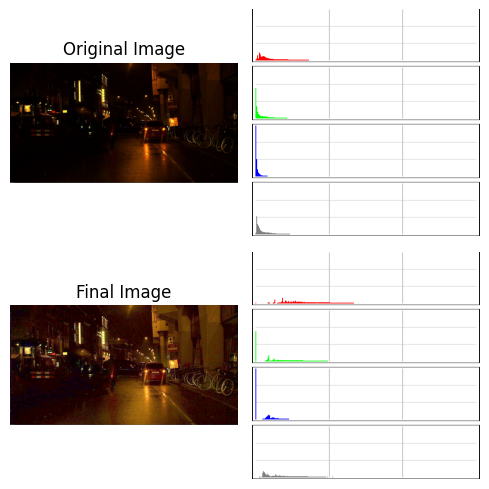

In [10]:
def LCC_RGB(input_path, input_hist_path, output_path, output_hist_path, radius):
    img = io.imread(input_path)
    Dx, Dy, _ = img.shape
    Dxy = Dx * Dy

    R, G, B = input2RGB(img.flatten())

    Rout, Gout, Bout = R.copy(), G.copy(), B.copy()

    Mask = Compute_Mask(radius, Dx, Dy)

    for n in range(Dxy):
        Mask[n] = 2 * Mask[n] - 1
        Mask[n] = 2.0 ** Mask[n]
        Rout[n] = R[n] ** Mask[n]
        Rout[n] = R[n] ** Mask[n]
        Gout[n] = G[n] ** Mask[n]
        Bout[n] = B[n] ** Mask[n]

    output = RGB2output(Rout, Gout, Bout, Dxy)
    output = output.reshape((Dx, Dy, 3))
    io.imsave(output_path, output)

    plot_output(input_path, input_hist_path, output_path, output_hist_path)

    return


LCC_RGB("i.jpg", "i_h.jpg", "o.jpg", "o_h.jpg", radius=40)

LCC - HSI

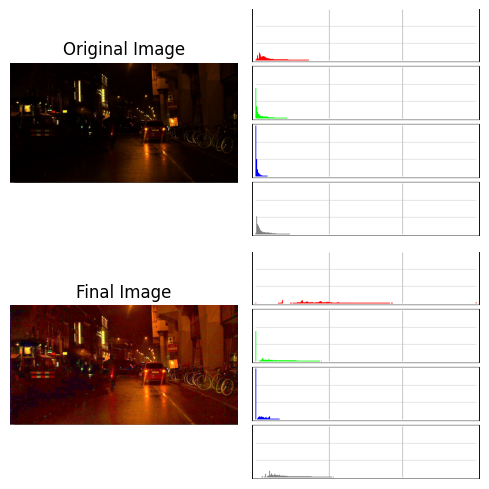

In [9]:
def LCC_HSI(input_path, input_hist_path, output_path, output_hist_path, radius):
    img = io.imread(input_path)
    Dx, Dy, _ = img.shape
    Dxy = Dx * Dy

    R, G, B = input2RGB(img.flatten())
    I = np.zeros(Dxy)

    Rout, Gout, Bout = R.copy(), G.copy(), B.copy()
    Iout = np.zeros(Dxy)

    Mask = Compute_Mask(radius, Dx, Dy)

    for n in range(Dxy):
        I[n] = (R[n] + G[n] + B[n]) / 3

    for n in range(Dxy):
        Mask[n] = 2 * Mask[n] - 1
        Mask[n] = 2.0 ** Mask[n]

        Iout[n] = I[n] ** Mask[n]

        if I[n] == 0:
            r = 0
        else:
            r = Iout[n] / I[n]

        rr, gg, bb = r * R[n], r * G[n], r * B[n]

        if (rr >= 1) or (gg >= 1) or (bb >= 1):
            if (R[n] >= G[n]) and (R[n] >= B[n]):
                r = 1 / R[n]
            if (G[n] >= R[n]) and (G[n] >= B[n]):
                r = 1 / G[n]
            if (B[n] >= R[n]) and (B[n] >= G[n]):
                r = 1 / B[n]
            rr, gg, bb = r * R[n], r * G[n], r * B[n]

        Rout[n], Gout[n], Bout[n] = rr, gg, bb

    output = RGB2output(Rout, Gout, Bout, Dxy)
    output = output.reshape((Dx, Dy, 3))
    io.imsave(output_path, output)

    plot_output(input_path, input_hist_path, output_path, output_hist_path)

    return


LCC_HSI("i.jpg", "i_h.jpg", "o.jpg", "o_h.jpg", radius=40)

LCC_HSL

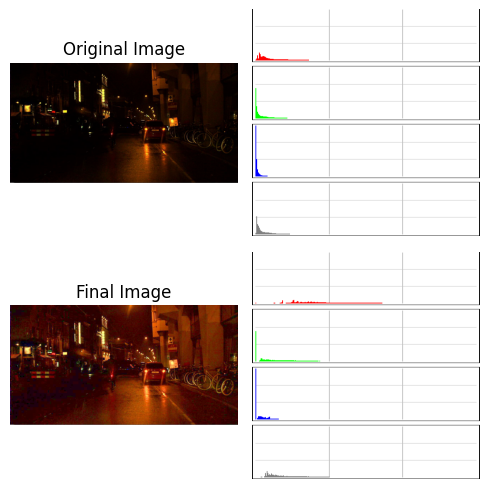

In [11]:
def hsl_to_rgb(H, S, L):
    C = 0
    if L <= 0.5:
        C = 2 * L * S
    else:
        C = (2 - 2 * L) * S

    Min = L - 0.5 * C
    H -= 360 * math.floor(H / 360)
    H /= 60
    X = C * (1 - abs(2 * math.floor(H / 2) - 1))

    switch_dict = {
        0: lambda: (Min + C, Min + X, Min),
        1: lambda: (Min + X, Min + C, Min),
        2: lambda: (Min, Min + C, Min + X),
        3: lambda: (Min, Min + X, Min + C),
        4: lambda: (Min + X, Min, Min + C),
        5: lambda: (Min + C, Min, Min + X),
        # Default case
        "default": lambda: (0, 0, 0),
    }

    # Use the dictionary to execute the corresponding case
    R, G, B = switch_dict.get(int(H), switch_dict["default"])()

    return R, G, B


def rgb_to_hsl(R, G, B):
    Max = max(R, G, B)
    Min = min(R, G, B)
    C = Max - Min
    H = 0
    L = (Max + Min) / 2

    if C > 0:
        if Max == R:
            H = (G - B) / C
            if G < B:
                H += 6
        elif Max == G:
            H = 2 + (B - R) / C
        else:
            H = 4 + (R - G) / C

        H *= 60

        if L <= 0.5:
            S = C / (2 * L)
        else:
            S = C / (2 - 2 * L)
    else:
        H = S = 0

    return H, S, L


def LCC_HSL(input_path, input_hist_path, output_path, output_hist_path, radius):
    img = io.imread(input_path)
    Dx, Dy, _ = img.shape
    Dxy = Dx * Dy

    R, G, B = input2RGB(img.flatten())
    I = np.zeros(Dxy)
    Rout, Gout, Bout = R.copy(), G.copy(), B.copy()
    Iout = np.zeros(Dxy)
    H = np.zeros(Dxy)
    S = np.zeros(Dxy)

    for n in range(Dxy):
        hh, ss, ll = rgb_to_hsl(R[n], G[n], B[n])
        H[n] = hh
        S[n] = ss
        I[n] = ll

    Mask = Compute_Mask(radius, Dx, Dy)

    for n in range(Dxy):
        Mask[n] = 2 * Mask[n] - 1
        Mask[n] = 2.0 ** Mask[n]

        Iout[n] = I[n] ** Mask[n]

        rr, gg, bb = hsl_to_rgb(H[n], S[n], Iout[n])
        Rout[n], Gout[n], Bout[n] = rr, gg, bb

    output = RGB2output(Rout, Gout, Bout, Dxy)
    output = output.reshape((Dx, Dy, 3))
    io.imsave(output_path, output)

    plot_output(input_path, input_hist_path, output_path, output_hist_path)

    return


LCC_HSL("i.jpg", "i_h.jpg", "o.jpg", "o_h.jpg", radius=40)

LCC - YPbPr

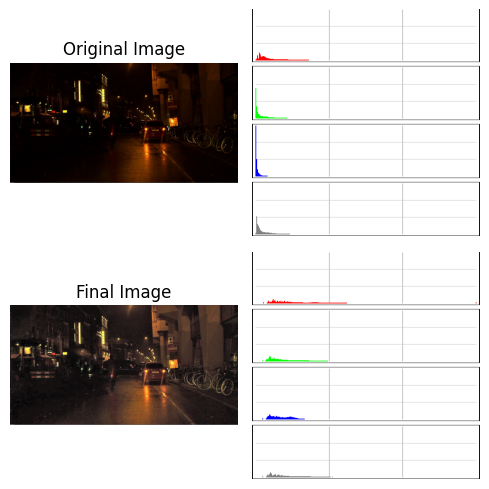

In [12]:
def ypbpr_to_rgb(Y, Pb, Pr):
    R = math.sqrt(Y) + 1.402 * Pr
    G = math.sqrt(Y) - 0.344136 * Pb - 0.714136 * Pr
    B = math.sqrt(Y) + 1.772 * Pb
    return R, G, B


def rgb_to_ypbpr(R, G, B):
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Pb = -0.1687367 * R - 0.331264 * G + 0.5 * B
    Pr = 0.5 * R - 0.418688 * G - 0.081312 * B
    return Y, Pb, Pr


def LCC_YPbPr(input_path, input_hist_path, output_path, output_hist_path, radius):
    img = io.imread(input_path)
    Dx, Dy, _ = img.shape
    Dxy = Dx * Dy

    R, G, B = input2RGB(img.flatten())
    Rout, Gout, Bout = R.copy(), G.copy(), B.copy()
    I = np.zeros(Dxy)
    Iout = np.zeros(Dxy)
    Pb = np.zeros(Dxy)
    Pr = np.zeros(Dxy)

    for n in range(Dxy):
        ii, ppb, ppr = rgb_to_ypbpr(R[n], G[n], B[n])
        I[n] = ii
        Pb[n] = ppb
        Pr[n] = ppr

    Mask = Compute_Mask(radius, Dx, Dy)

    for n in range(Dxy):
        Mask[n] = 2 * Mask[n] - 1
        Mask[n] = 2.0 ** Mask[n]

        Iout[n] = I[n] ** Mask[n]

        rr, gg, bb = ypbpr_to_rgb(Iout[n], Pb[n], Pr[n])
        Rout[n], Gout[n], Bout[n] = rr, gg, bb

    output = RGB2output(Rout, Gout, Bout, Dxy)
    output = output.reshape((Dx, Dy, 3))
    io.imsave(output_path, output)

    plot_output(input_path, input_hist_path, output_path, output_hist_path)

    return


LCC_YPbPr("i.jpg", "i_h.jpg", "o.jpg", "o_h.jpg", radius=40)